### This notebook is to look at delirium data closely, do some EDA.

## Imports

In [29]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy import func, select, desc
from sqlalchemy.sql.expression import and_

import config
from cyclops.orm import DB

## Load config, setup ORM

In [30]:
cfg = config.read_config("../configs/default/*.yaml")
db = DB(cfg)

## String constants

In [35]:
GENC_ID = "genc_id"
PATIENT_ID = "patient_id"
HOSPITAL_ID = "hospital_id"
AGE = "age"
GENDER = "gender"
UNIQUE_LAB_NAMES = "unique_lab_names"
UNIQUE_LAB_COUNTS = "unique_lab_counts"
LAB_TEST_NAME = "lab_test_name"
UNIQUE_VITALS_NAMES = "unique_vitals_names"
UNIQUE_VITALS_COUNTS = "unique_vitals_counts"
VITALS_NAME = "vitals_name"

## Delirium data distribution

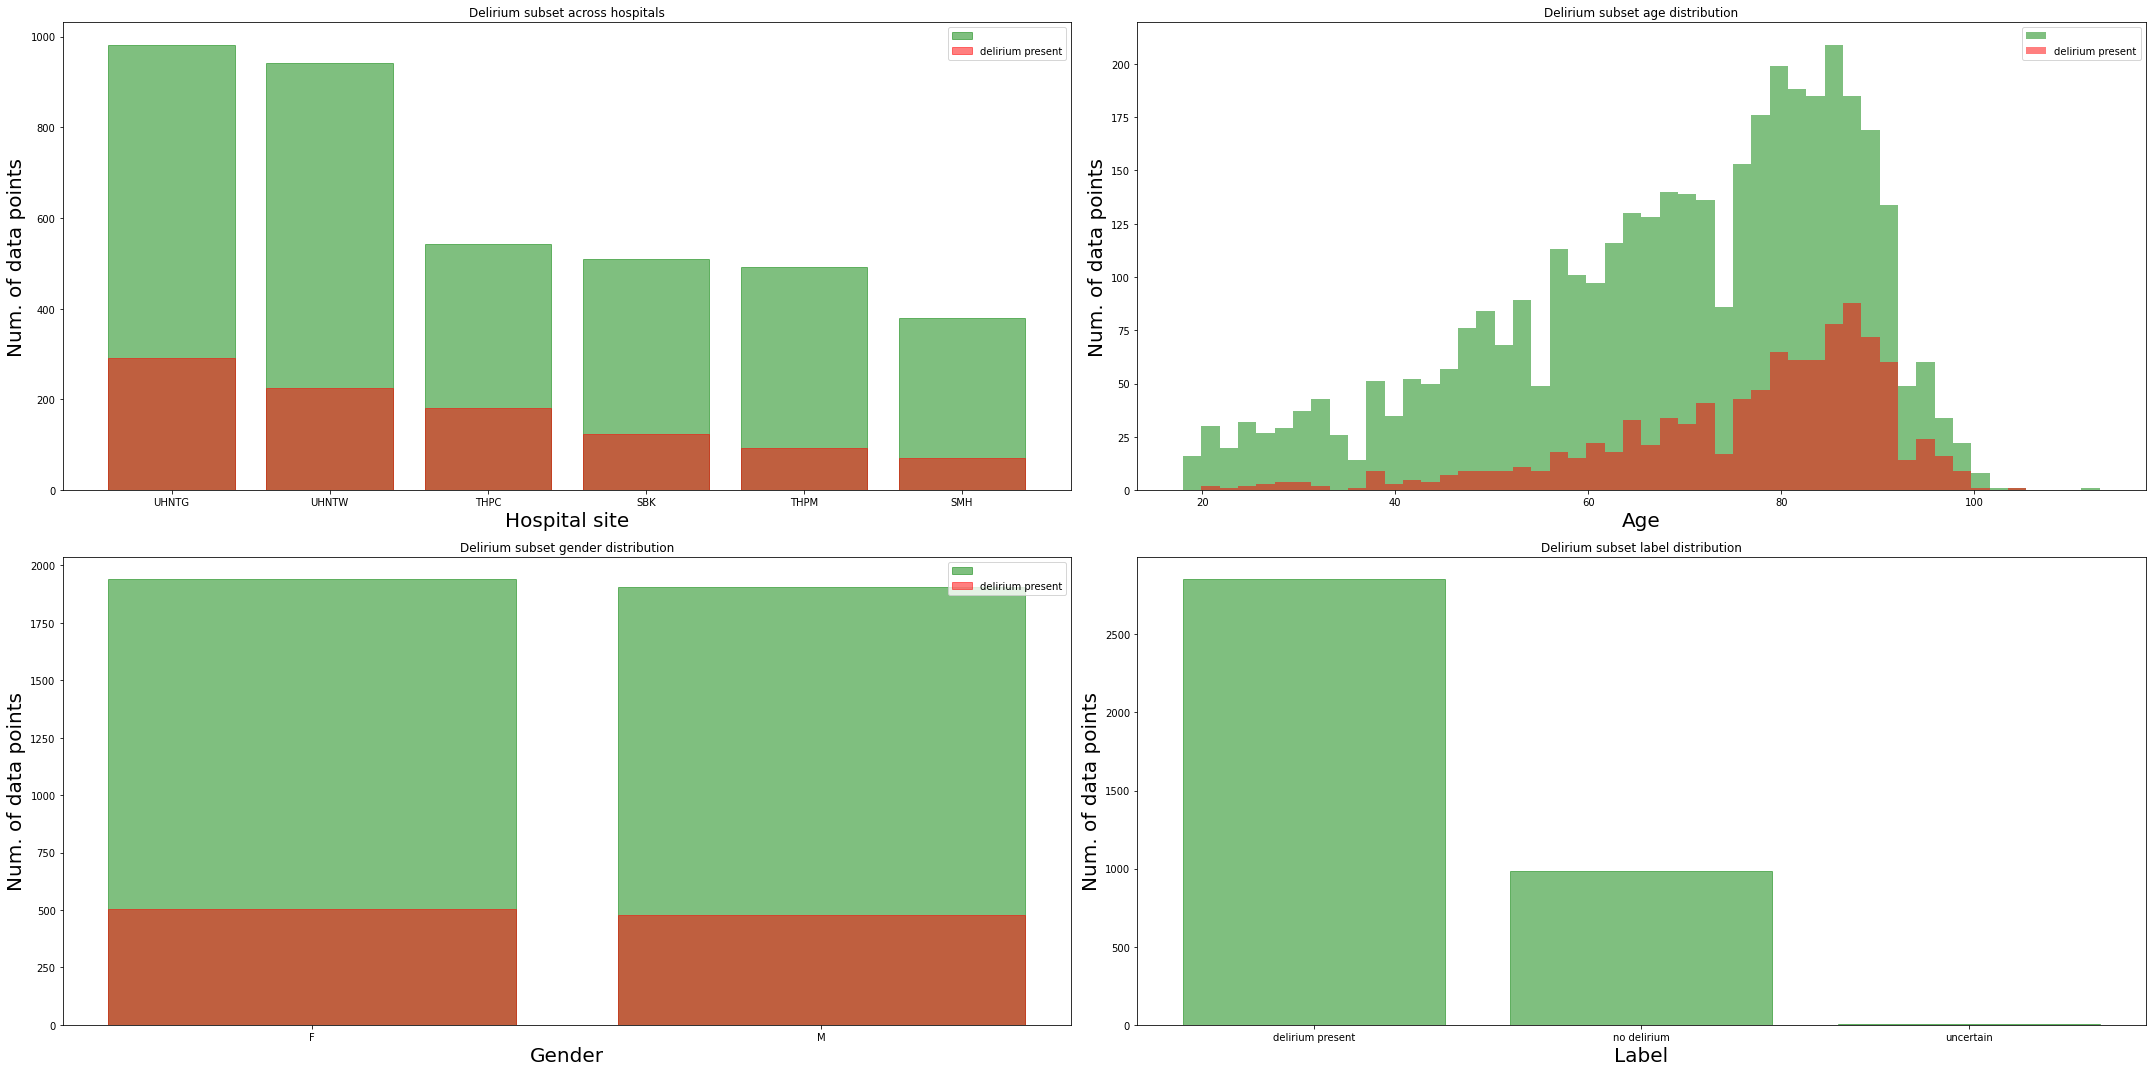

In [32]:
delirium_admin_query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
                              db.public.ip_administrative.genc_id,
                              db.public.ip_administrative.hospital_id,
                              db.public.ip_administrative.admit_date_time,
                              db.public.ip_administrative.age,
                              db.public.ip_administrative.gender,
                              db.public.ip_administrative.discharge_date_time,
                              db.public.ip_administrative.del_present,
                              db.public.ip_administrative.gemini_cohort
                             ).where(db.public.ip_administrative.gemini_cohort == True).subquery()
admin_data = db.run_query(delirium_admin_query)
admin_data_pos = admin_data.loc[admin_data["del_present"] == 1]


fig, axs = plt.subplots(2, 2, figsize=(30, 15), tight_layout=True)

# Across hospitals
hosp_counts = list(admin_data[HOSPITAL_ID].value_counts())
hospitals = list(admin_data[HOSPITAL_ID].unique())
hosp_counts_pos = list(admin_data_pos[HOSPITAL_ID].value_counts())

hosp_bars = axs[0][0].bar(hospitals, hosp_counts, alpha = 0.5)
for bar in hosp_bars:
    bar.set_color('g')
hosp_bars_pos = axs[0][0].bar(hospitals, hosp_counts_pos, alpha = 0.5)
for bar in hosp_bars_pos:
    bar.set_color('r')
axs[0][0].title.set_text("Delirium subset across hospitals")
axs[0][0].set_xlabel("Hospital site", fontsize=20)
axs[0][0].set_ylabel("Num. of data points", fontsize=20)
lgnd = ['', 'delirium present']
axs[0][0].legend(lgnd, loc=1)

# Across age
ages = admin_data[AGE]
ages_pos = admin_data_pos[AGE]

(_, bins, _) = axs[0][1].hist(ages, bins=50, alpha=0.5, color='g')
axs[0][1].hist(ages_pos, bins=bins, alpha=0.5, color='r')
axs[0][1].title.set_text("Delirium subset age distribution")
axs[0][1].set_xlabel("Age", fontsize=20)
axs[0][1].set_ylabel("Num. of data points", fontsize=20)
axs[0][1].legend(lgnd, loc=1)

# Across gender
genders = list(admin_data[GENDER].unique())
gender_counts = list(admin_data[GENDER].value_counts())
gender_counts_pos = list(admin_data_pos[GENDER].value_counts())

gender_bars = axs[1][0].bar(genders, gender_counts, alpha = 0.5)
for bar in gender_bars:
    bar.set_color('g')
gender_bars_pos = axs[1][0].bar(genders, gender_counts_pos, alpha = 0.5)
for bar in gender_bars_pos:
    bar.set_color('r')
axs[1][0].title.set_text("Delirium subset gender distribution")
axs[1][0].set_xlabel("Gender", fontsize=20)
axs[1][0].set_ylabel("Num. of data points", fontsize=20)
axs[1][0].legend(lgnd, loc=1)

# Across labels
DEL_LABEL_MAP = {
    1: "delirium present",
    2: "no delirium",
    3: "uncertain"
}
label_counts = list(admin_data['del_present'].value_counts())
labels = list(admin_data['del_present'].unique())
labels = [DEL_LABEL_MAP[l] for l in labels]

label_bars = axs[1][1].bar(labels, label_counts, alpha = 0.5)
for bar in label_bars:
    bar.set_color('g')
axs[1][1].title.set_text("Delirium subset label distribution")
axs[1][1].set_xlabel("Label", fontsize=20)
axs[1][1].set_ylabel("Num. of data points", fontsize=20)


plt.show()

## Find out unique lab tests

In [33]:
"""Unique lab names and counts. Get top k lab tests ordered.

`lab_test_name_mapped` has common tests mapped across sites by GEMINI.
`lab_test_name_raw` has raw test names which are much greater in number (most different, unmapped across sites).
"""

k = 54

unique_lab_names = func.lower(db.public.lab.lab_test_name_mapped)
query = select(unique_lab_names.label(UNIQUE_LAB_NAMES),
               func.count(unique_lab_names).label(UNIQUE_LAB_COUNTS)
              )
query = query.group_by(UNIQUE_LAB_NAMES).order_by(desc(UNIQUE_LAB_COUNTS))

lab_counts = db.run_query(query)
print(f"Num. of unique lab tests: {len(lab_counts)}")
print(lab_counts.head(k))

Num. of unique lab tests: 55
                          unique_lab_names  unique_lab_counts
0                                   sodium            3043713
1                                potassium            2620534
2                               lymphocyte            2555905
3                               hemoglobin            2405465
4                               creatinine            2371876
5                              bicarbonate            2325705
6                   white blood cell count            2310123
7                           platelet count            2307750
8                   mean cell volume (mcv)            2299557
9                               hematocrit            2258974
10                             neutrophils            2193498
11                   glucose point of care            1840409
12                              urinalysis            1405597
13                          glucose random            1279665
14               blood urea nitrogen (bun

## Get the mapped lab tests for patients with delirium label

In [36]:
common_lab_tests = list(lab_counts.head(k)[UNIQUE_LAB_NAMES])
lab_test_name = func.lower(db.public.lab.lab_test_name_mapped)
lab_query = select(db.public.lab.genc_id,
                   lab_test_name.label(LAB_TEST_NAME),
                   db.public.lab.result_value,
                   db.public.lab.result_unit,
                   db.public.lab.sample_collection_date_time).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.admit_date_time,
               db.public.ip_administrative.discharge_date_time,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               lab_query.c.lab_test_name,
               lab_query.c.result_value,
               lab_query.c.result_unit,
               lab_query.c.sample_collection_date_time,
              ).join(lab_query,
                     db.public.ip_administrative.genc_id == lab_query.c.genc_id
                    ).where(and_(lab_query.c.lab_test_name.in_(common_lab_tests),
                                 db.public.ip_administrative.gemini_cohort == True))
labs = db.run_query(query)
print(labs[GENC_ID].nunique())

3837


## Plot distribution of lab tests ordered (delirium subset vs. all patients)

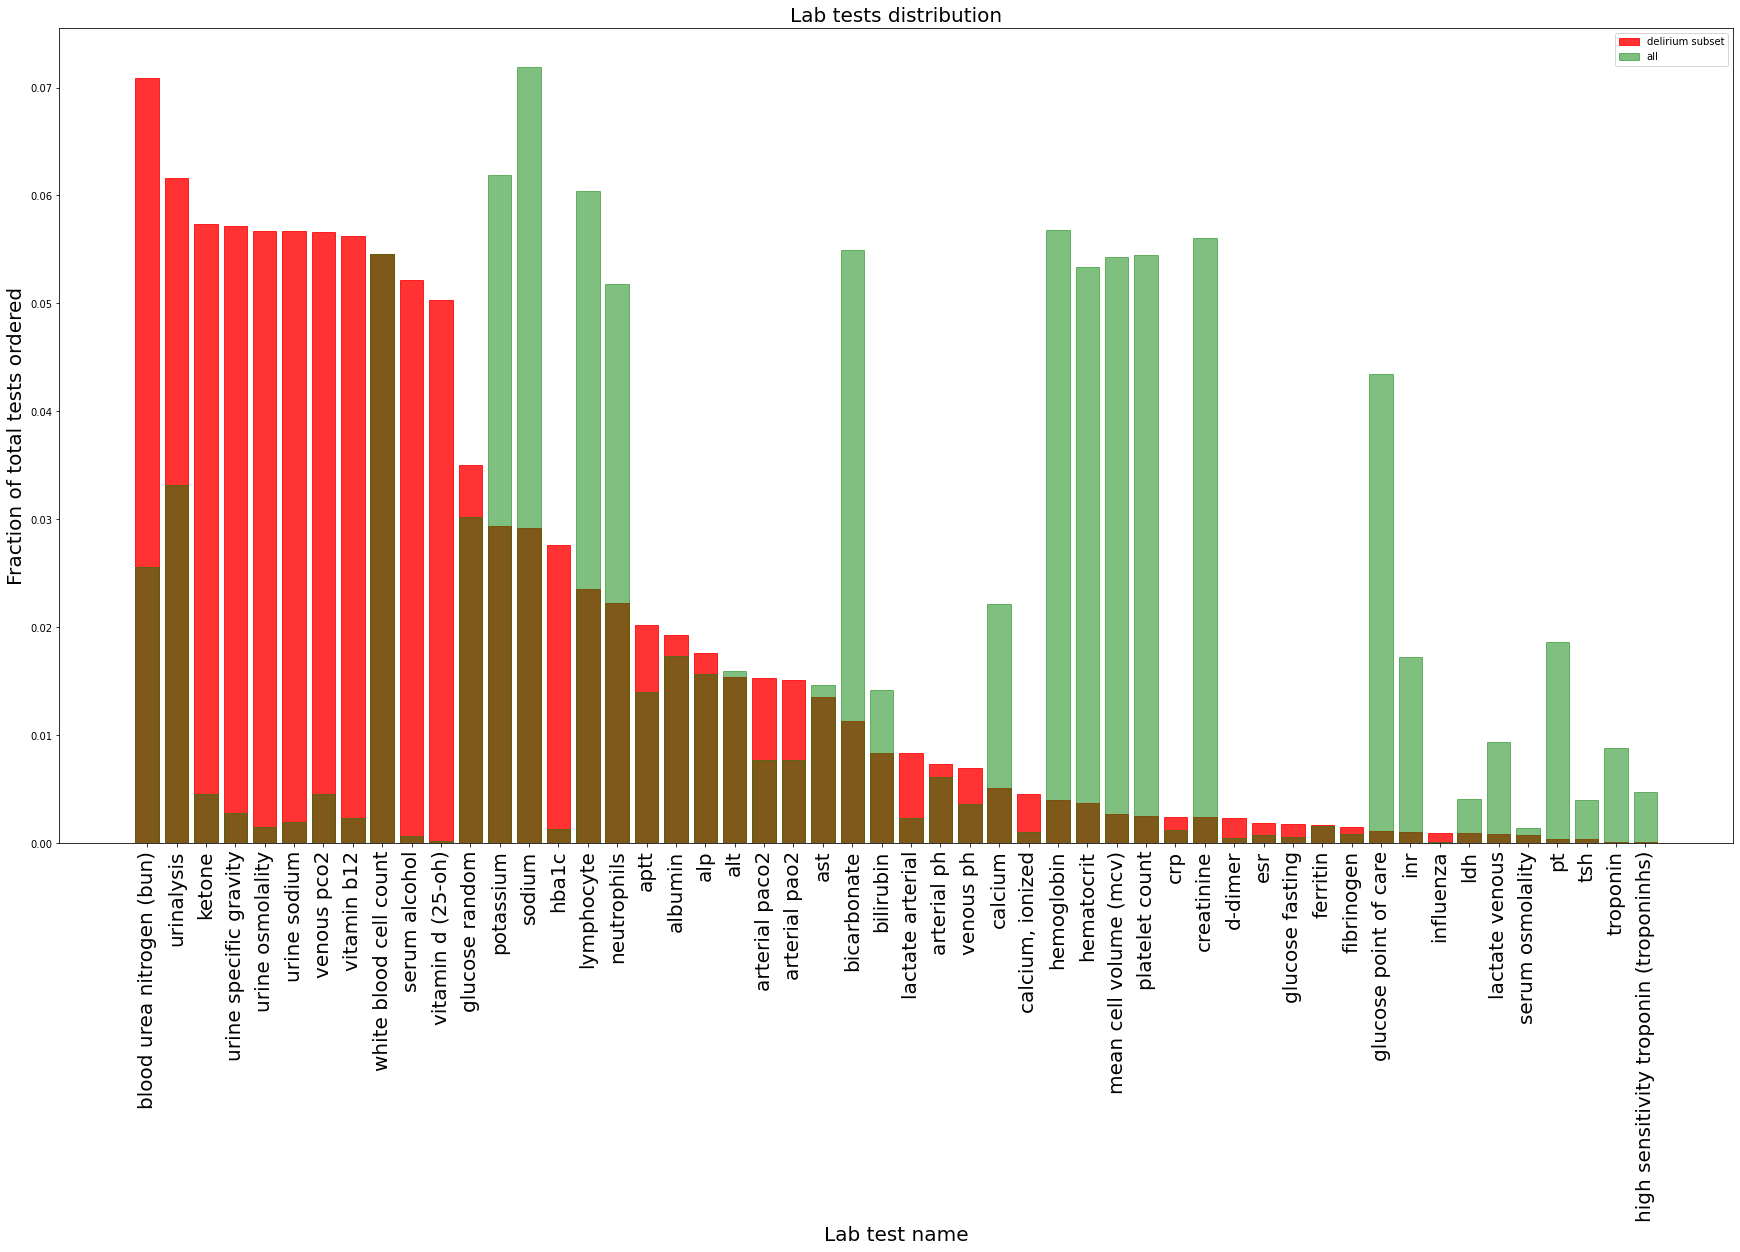

In [37]:
del_lab_names = list(labs[LAB_TEST_NAME].unique())
del_lab_counts = list(labs[LAB_TEST_NAME].value_counts())
del_lab_counts = np.array(del_lab_counts) / sum(del_lab_counts)

all_lab_counts = [int(lab_counts.loc[lab_counts[UNIQUE_LAB_NAMES] == ln][UNIQUE_LAB_COUNTS]) for ln in del_lab_names]
all_lab_counts = np.array(all_lab_counts) / sum(all_lab_counts)

fig = plt.figure(figsize=(30, 15))
delirum_labs_bars = plt.bar(list(range(len(del_lab_names))), del_lab_counts, alpha = 0.8)
for bar in delirum_labs_bars:
    bar.set_color('r')
all_labs_bars = plt.bar(list(range(len(del_lab_names))), all_lab_counts, alpha = 0.5)
for bar in all_labs_bars:
    bar.set_color('g')
plt.xticks(range(len(delirum_labs_bars)), del_lab_names, rotation='vertical', fontsize=20)
plt.title("Lab tests distribution", fontsize=20)
plt.xlabel("Lab test name", fontsize=20)
plt.ylabel("Fraction of total tests ordered", fontsize=20)

lgnd = ['delirium subset', 'all']
plt.legend(lgnd, loc=1)
plt.show()

## Lab tests distribution across sites (delirium).

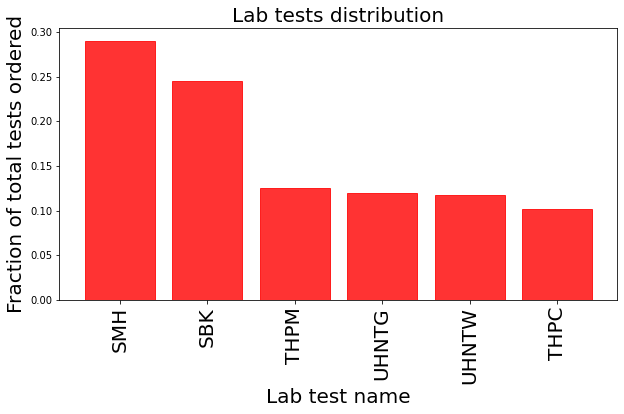

In [51]:
lab_counts_hosp = labs[HOSPITAL_ID].value_counts()
fig = plt.figure(figsize=(10, 5))
labs_hosp_bars = plt.bar(list(range(len(lab_counts_hosp))), np.array(lab_counts_hosp.values) / sum(lab_counts_hosp.values), alpha = 0.8)
for bar in labs_hosp_bars:
    bar.set_color('r')
plt.xticks(range(len(labs_hosp_bars)), lab_counts_hosp.keys(), rotation='vertical', fontsize=20)
plt.title("Lab tests distribution", fontsize=20)
plt.xlabel("Lab test name", fontsize=20)
plt.ylabel("Fraction of total tests ordered", fontsize=20)
plt.show()

## TODO: Extract lab result values, units

## Find out mapped/unique vital measurements

In [38]:
"""Unique vital measurement names and counts. Get top k vitals measured.

`measurement_mapped` has common vital measurements mapped across sites by GEMINI.
`measurement_name` has raw vitals names which are much greater in number (most different, unmapped across sites).
"""

k = 11

unique_vitals_names = func.lower(db.public.vitals.measurement_mapped)
query = select(unique_vitals_names.label(UNIQUE_VITALS_NAMES),
               func.count(unique_vitals_names).label(UNIQUE_VITALS_COUNTS)
              )
query = query.group_by(UNIQUE_VITALS_NAMES).order_by(desc(UNIQUE_VITALS_COUNTS))

vitals_counts = db.run_query(query)
print(f"Num. of unique vitals measurements: {len(vitals_counts)}")
print(vitals_counts.head(k))

Num. of unique vitals measurements: 12
   unique_vitals_names  unique_vitals_counts
0          temperature               1056374
1           heart rate                839616
2          systolic bp                837673
3         diastolic bp                837591
4    oxygen saturation                681903
5     respiratory rate                671321
6      oxygen_delivery                609249
7                  cam                472200
8                 fio2                445510
9     oxygen flow rate                335422
10              weight                120526


## Get the mapped vitals for patients with delirium label

In [39]:
common_vitals = list(vitals_counts.head(k)[UNIQUE_VITALS_NAMES])
vitals_name = func.lower(db.public.vitals.measurement_mapped)
vitals_query = select(db.public.vitals.genc_id,
                      vitals_name.label(VITALS_NAME)).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               vitals_query.c.vitals_name,
              ).join(vitals_query,
                     db.public.ip_administrative.genc_id == vitals_query.c.genc_id
                    ).where(and_(vitals_query.c.vitals_name.in_(common_vitals),
                                 db.public.ip_administrative.gemini_cohort == True))
vitals = db.run_query(query)
print(vitals[GENC_ID].nunique())


# No vitals data for delirium subset??? Maybe ask why?

0
